In [1]:
%matplotlib notebook

from collections import Counter
import dill
import glob
import igraph as ig
import itertools
import leidenalg
#import magic
import matplotlib
from matplotlib import pyplot
import numba
import numpy
import os
import pickle
from plumbum import local
import random
import re
import scipy
from scipy.cluster import hierarchy
import scipy.sparse as sps
from scipy.spatial import distance
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn import neighbors
from sklearn import metrics
import sys
import umap

#from plotly import tools
#import plotly.offline as py
#import plotly.graph_objs as go
#py.init_notebook_mode(connected=True)

src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
def find_nearest_genes(peak_files, out_subdir, refseq_exon_bed):
    #get unix utilities
    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']

    #process the peak files to find nearest genes
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)
    return nearest_genes

def load_expr_db(db_path):
    if os.path.basename(db_path) == 'RepAvgGeneTPM.csv':
        with open(db_path) as lines_in:
            db_headers = lines_in.readline().strip().split(',')[1:]
        db_vals = numpy.loadtxt(db_path, delimiter=',', skiprows=1, dtype=object)[:,1:]
    else:
        with open(db_path) as lines_in:
            db_headers = lines_in.readline().strip().split('\t')
        db_vals = numpy.loadtxt(db_path, delimiter='\t', skiprows=1, dtype=object)
    print('Loaded DB shape: {!s}'.format(db_vals.shape))
    return (db_headers, db_vals)

TOPN=500
def get_gene_data(genes_path, gene_expr_db, topn=TOPN):
    if isinstance(genes_path, list):
        genes_list = genes_path
    else:
        with open(genes_path) as lines_in:
            genes_list = [elt.strip().split()[:2] for elt in lines_in]
    gene_idx = [(numpy.where(gene_expr_db[:,0] == elt[0])[0],elt[1]) for elt in genes_list]
    gene_idx_sorted = sorted(gene_idx, key=lambda x:float(x[1]), reverse=True)
    gene_idx, gene_weights = zip(*[elt for elt in gene_idx_sorted if len(elt[0]) > 0][:topn])
    gene_idx = [elt[0] for elt in gene_idx]
    gene_data = gene_expr_db[:,1:].astype(float)[gene_idx,:]
    denom = numpy.sum(gene_data, axis=1)[:,None] + 1e-8
    gene_norm = gene_data/denom
    return gene_idx, gene_data, gene_norm, len(genes_list), numpy.array(gene_weights, dtype=float)

def sample_db(data_norm, expr_db, data_weights=None, nsamples=1000):
    samples = []
    rs = numpy.random.RandomState(15321)
    random_subset = numpy.arange(expr_db.shape[0])
    num_to_select = data_norm.shape[0]
    for idx in range(nsamples):
        rs.shuffle(random_subset)
        if expr_db.shape[1] - data_norm.shape[1] == 1:
            db_subset = expr_db[random_subset[:num_to_select]][:,1:].astype(float)
        else:
            db_subset = expr_db[random_subset[:num_to_select]].astype(float)
        denom = numpy.sum(db_subset, axis=1)[:None] + 1e-8
        db_subset_norm = numpy.mean((db_subset.T/denom).T, axis=0)
        if data_weights is not None:
            samples.append(numpy.log2(numpy.average(data_norm, axis=0, weights=gene_weights)/db_subset_norm))
        else:
            samples.append(numpy.log2(numpy.average(data_norm, axis=0, weights=None)/db_subset_norm))
    samples = numpy.vstack(samples)
    samples_mean = numpy.mean(samples, axis=0)
    samples_sem = stats.sem(samples, axis=0)
    conf_int = numpy.array([stats.t.interval(0.95, samples.shape[0]-1, 
                                             loc=samples_mean[idx], scale=samples_sem[idx])
                            for idx in range(samples.shape[1])]).T
    conf_int[0] = samples_mean - conf_int[0]
    conf_int[1] = conf_int[1] - samples_mean
    return samples_mean, conf_int

def plot_l2_tissues(nearest_genes_glob, refdata, allgenes_path=None, expr_db=None, expr_db_headers=None, ncols=3, 
                    topn=TOPN, weights=False, nsamples=100, savefile=None, display_in_notebook=True, dpi=None,
                    figsize_factor=7):
    if expr_db is None:
        #Get all L2 tissue expression data to normalize the distribution of genes from peaks
        l2_tissue_db_path = os.path.join(refdata,'gexplore_l2_tissue_expr.txt')
        expr_db_headers, expr_db = load_expr_db(l2_tissue_db_path)
    
    gene_lists = glob.glob(nearest_genes_glob)
    if os.path.basename(gene_lists[0]).startswith('peaks'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[0].replace('peaks', '')))
    elif os.path.basename(gene_lists[0]).startswith('topic'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[1].replace('rank', '')))
    else:
        gene_lists.sort(key=lambda x:os.path.basename(x).split('.')[0])
    gene_list_data = [(os.path.basename(path).split('.')[0], get_gene_data(path, expr_db, topn=topn)) for path in gene_lists]
    print('\n'.join(['{!s} nearest genes: found {!s} out of {!s} total'.format(fname, data.shape[0], gene_list_len)
                    for (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in gene_list_data]))
    
    if allgenes_path is not None:
        allgenes_norm = get_gene_data(allgenes_path, expr_db, topn=100000)[2]

    l2_tissue_colors = [('Body wall muscle', '#e51a1e'),
                        ('Intestinal/rectal muscle', '#e51a1e'),
                        ('Pharyngeal muscle', '#377db8'),
                        ('Pharyngeal epithelia', '#377db8'),
                        ('Pharyngeal gland', '#377db8'),
                        ('Seam cells', '#4eae4a'),
                        ('Non-seam hypodermis', '#4eae4a'),
                        ('Rectum', '#4eae4a'),
                        ('Ciliated sensory neurons', '#984ea3'),
                        ('Oxygen sensory neurons', '#984ea3'),
                        ('Touch receptor neurons', '#984ea3'),
                        ('Cholinergic neurons', '#984ea3'),
                        ('GABAergic neurons', '#984ea3'),
                        ('Pharyngeal neurons', '#984ea3'),
                        ('flp-1(+) interneurons', '#984ea3'),
                        ('Other interneurons', '#984ea3'),
                        ('Canal associated neurons', '#984ea3'),
                        ('Am/PH sheath cells', '#ff8000'),
                        ('Socket cells', '#ff8000'),
                        ('Excretory cells', '#ff8000'),
                        ('Intestine', '#fcd800'),
                        ('Germline', '#f97fc0'),
                        ('Somatic gonad precursors', '#f97fc0'),
                        ('Distal tip cells', '#f97fc0'),
                        ('Vulval precursors', '#f97fc0'),
                        ('Sex myoblasts', '#f97fc0'),
                        ('Coelomocytes', '#a75629')]
    idx_by_color = {}
    for idx, (name, color) in enumerate(l2_tissue_colors):
        try:
            idx_by_color[color][1].append(idx)
        except KeyError:
            idx_by_color[color] = [name, [idx]]
            
#    rs = numpy.random.RandomState(15321)
#    random_subset = numpy.arange(expr_db.shape[0])
#    rs.shuffle(random_subset)
#    #num_to_select = int(numpy.mean([neuron_data.shape[0], emb_muscle_data.shape[0], l2_muscle_data.shape[0]]))
#    num_to_select = len(random_subset)
#    l2_tissue_db_subset = expr_db[random_subset[:num_to_select]][:,1:].astype(float)
#    denom = numpy.sum(l2_tissue_db_subset, axis=1)[:,None] + 1e-8
#    l2_tissue_db_norm = numpy.mean(l2_tissue_db_subset/denom, axis=0)
    print('Tissue DB norm shape: {!s}'.format(expr_db.shape))

    pyplot.rcParams.update({'xtick.labelsize':14,
                            'ytick.labelsize':14,
                            'xtick.major.pad':8})

    ind = numpy.arange(len(expr_db_headers) - 1)
    width = 0.66
    axis_fontsize = 18
    title_fontsize = 19
    nrows = int(numpy.ceil(len(gene_list_data)/float(ncols)))
    if dpi is not None:
        fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, 
                                    figsize=(figsize_factor * ncols, figsize_factor * nrows), 
                                    sharey=True, dpi=dpi)
    else:
        fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, 
                                    figsize=(figsize_factor * ncols, figsize_factor * nrows), 
                                    sharey=True)
    for idx, (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in enumerate(gene_list_data):
        ax_idx = (idx//ncols, idx%ncols) if nrows > 1 else idx
#        to_plot = numpy.log2(numpy.mean(data_norm, axis=0)/l2_tissue_db_norm)
#        import pdb; pdb.set_trace()
        if weights is True:
#            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=gene_weights)/l2_tissue_db_norm)
            to_plot, errs = sample_db(data_norm, expr_db if allgenes_path is None else allgenes_norm, 
                                      data_weights=gene_weights, nsamples=nsamples)
        else:
#            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=None)/l2_tissue_db_norm)
            to_plot, errs = sample_db(data_norm, expr_db if allgenes_path is None else allgenes_norm, 
                                      data_weights=None, nsamples=nsamples)
        for idx2, (name, color) in enumerate(l2_tissue_colors):
            axes[ax_idx[0],ax_idx[1]].bar(ind[idx2], to_plot[idx2], width, yerr=errs[:,idx2][:,None], color=color, label=name)
        axes[ax_idx[0],ax_idx[1]].axhline(0, color='k')
        axes[ax_idx[0],ax_idx[1]].set_xlim((-1, len(expr_db_headers)))
        axes[ax_idx[0],ax_idx[1]].set_title('{!s}\n({!s} genes)\n'.format(fname, data.shape[0]), fontsize=title_fontsize)
        axes[ax_idx[0],ax_idx[1]].set_ylabel('Log2 ratio of mean expr proportion\n(ATAC targets:Random genes)', fontsize=axis_fontsize)
        axes[ax_idx[0],ax_idx[1]].set_xlabel('L2 tissues', fontsize=axis_fontsize)
        axes[ax_idx[0],ax_idx[1]].set_xticks(ind + width/2)
        axes[ax_idx[0],ax_idx[1]].set_xticklabels([])
    #axes[0].set_xticklabels(expr_db_headers[1:], rotation=90)
    if nrows > 1:
        axes[0,ncols-1].legend(bbox_to_anchor=[1.0,1.0])
    else:
        axes[-1].legend(bbox_to_anchor=[1.0,1.0])

    if display_in_notebook is True:
        fig.tight_layout()
    if savefile is not None:
        fig.savefig(savefile, bbox_inches='tight')

def plot_stages(nearest_genes_glob, refdata, expr_db=None, expr_db_headers=None, ncols=3, topn=TOPN, weights=False):
    if expr_db is None:
        #Get all stages expression data to normalize the distribution of genes from peaks
        stage_db_path = os.path.join(refdata,'gexplore_stage_expr.txt')
        expr_db_headers, expr_db = load_expr_db(stage_db_path)

    gene_lists = glob.glob(nearest_genes_glob)
    if os.path.basename(gene_lists[0]).startswith('peaks'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[0].replace('peaks', '')))
    elif os.path.basename(gene_lists[0]).startswith('topic'):
        gene_lists.sort(key=lambda x:int(os.path.basename(x).split('.')[1].replace('rank', '')))
    else:
        gene_lists.sort(key=lambda x:os.path.basename(x).split('.')[0])
    gene_list_data = [(os.path.basename(path).split('.')[0], get_gene_data(path, expr_db, topn=topn)) for path in gene_lists]
    print('\n'.join(['{!s} nearest genes: found {!s} out of {!s} total'.format(fname, data.shape[0], gene_list_len)
                    for (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in gene_list_data]))
    
    rs = numpy.random.RandomState(15321)
    random_subset = numpy.arange(expr_db.shape[0])
    rs.shuffle(random_subset)
    #num_to_select = int(numpy.mean([neuron_data.shape[0], emb_muscle_data.shape[0], l2_muscle_data.shape[0]]))
    num_to_select = len(random_subset)
    stage_db_subset = expr_db[random_subset[:num_to_select]][:,1:].astype(float)
    denom = numpy.sum(stage_db_subset, axis=1)[:,None] + 1e-8
    stage_db_norm = numpy.mean(stage_db_subset/denom, axis=0)
    print('Stage DB norm shape: {!s}'.format(stage_db_norm.shape))

    emb_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:] 
               if elt.endswith('m') or elt == '4-cell']
    larva_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:] 
                 if elt.startswith('L')]
    adult_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:]
                if 'adult' in elt]
    dauer_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:]
                if 'dauer' in elt]
#    rest_idx = [expr_db_headers[1:].index(elt) for elt in expr_db_headers[1:] 
#                if not elt.endswith('m') and not elt.startswith('L') and elt != '4-cell']

    pyplot.rcParams.update({'xtick.labelsize':20,
                            'ytick.labelsize':20,
                            'xtick.major.pad':8})

    ind = numpy.arange(len(expr_db_headers) - 1)
    width = 0.66
    axis_fontsize = 25
    title_fontsize = 27
    nrows = int(numpy.ceil(len(gene_list_data)/float(ncols)))
    fig, axes = pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, 7 * nrows), sharey=True)
    for idx, (fname, (data_idx, data, data_norm, gene_list_len, gene_weights)) in enumerate(gene_list_data):
        ax_idx = (idx//ncols, idx%ncols) if nrows > 1 else idx
#        to_plot = numpy.log2(numpy.mean(data_norm, axis=0)/stage_db_norm)
        if weights is True:
            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=gene_weights)/stage_db_norm)
        else:
            to_plot = numpy.log2(numpy.average(data_norm, axis=0, weights=None)/stage_db_norm)
        axes[ax_idx].bar(ind[emb_idx], to_plot[emb_idx], width, color='orange', label='Embryo')
        axes[ax_idx].bar(ind[larva_idx], to_plot[larva_idx], width, color='blue', label='Larva')
        axes[ax_idx].bar(ind[adult_idx], to_plot[adult_idx], width, color='red', label='Adult')
        axes[ax_idx].bar(ind[dauer_idx], to_plot[dauer_idx], width, color='green', label='Dauer')
#        axes[ax_idx].bar(ind[rest_idx], to_plot[rest_idx], width, color='grey', label='Other')
        axes[ax_idx].axhline(0, color='k')
        axes[ax_idx].set_xlim((-1, len(expr_db_headers)))
        axes[ax_idx].set_title('{!s}\n({!s} genes)\n'.format(fname, data.shape[0]), fontsize=title_fontsize)
        axes[ax_idx].set_ylabel('Log2 Ratio of Mean Expr Proportion\n(ATAC Targets:All Genes)', fontsize=axis_fontsize)
        axes[ax_idx].set_xlabel('Developmental Stage', fontsize=axis_fontsize)
        axes[ax_idx].set_xticks(ind + width/2)
        axes[ax_idx].set_xticklabels([])

    fig.tight_layout()

def leiden_clustering(umap_res, resolution_range=(0,1), random_state=2, kdtree_dist='euclidean'):
    tree = neighbors.KDTree(umap_res, metric=kdtree_dist)
    vals, i, j = [], [], []
    for idx in range(umap_res.shape[0]):
        dist, ind = tree.query([umap_res[idx]], k=25)
        vals.extend(list(dist.squeeze()))
        j.extend(list(ind.squeeze()))
        i.extend([idx] * len(ind.squeeze()))
    print(len(vals))
    ginput = sps.csc_matrix((numpy.array(vals), (numpy.array(i),numpy.array(j))), 
                            shape=(umap_res.shape[0], umap_res.shape[0]))
    sources, targets = ginput.nonzero()
    edgelist = zip(sources.tolist(), targets.tolist())
    G = ig.Graph(edges=list(edgelist))
    optimiser = leidenalg.Optimiser()
    optimiser.set_rng_seed(random_state)
    profile = optimiser.resolution_profile(G, leidenalg.CPMVertexPartition, resolution_range=resolution_range, number_iterations=0)
    print([len(elt) for elt in profile])
    return profile

def write_peaks_and_map_to_genes(data_array, row_headers, c_labels, out_dir, refseq_exon_bed, 
                                 uniqueness_threshold=3, num_peaks=1000):
    #write the peaks present in each cluster to bed files
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    else:
        local['rm']('-r', out_dir)
        os.makedirs(out_dir)
    
    #write a file of peaks per cluster in bed format
    peak_files = []
    for idx, cluster_name in enumerate(sorted(set(c_labels))):
        cell_coords = numpy.where(c_labels == cluster_name)
        peak_sums = numpy.mean(data_array[:,cell_coords[0]], axis=1)
        peak_sort = numpy.argsort(peak_sums)
#        sorted_peaks = peak_sums[peak_sort]
#        print('Cluster {!s} -- Present Peaks: {!s}, '
#              'Min Peaks/Cell: {!s}, '
#              'Max Peaks/Cell: {!s}, '
#              'Peaks in {!s}th cell: {!s}'.format(cluster_name, numpy.sum(peak_sums > 0), 
#                                                  sorted_peaks[0], sorted_peaks[-1], 
#                                                  num_peaks, sorted_peaks[-num_peaks]))
        out_tmp = os.path.join(out_dir, 'peaks{!s}.tmp.bed'.format(cluster_name))
        out_path = out_tmp.replace('.tmp', '')
        peak_indices = peak_sort[-num_peaks:]
        with open(out_tmp, 'w') as out:
            out.write('\n'.join('chr'+'\t'.join(elt) if not elt[0].startswith('chr') else '\t'.join(elt) 
                                for elt in numpy.hstack([row_headers[peak_indices],
                                                         peak_sums[peak_indices,None].astype(str)])) + '\n')
        (local['sort']['-k1,1', '-k2,2n', out_tmp] > out_path)()
        os.remove(out_tmp)
        peak_files.append(out_path)

    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']
    out_subdir = os.path.join(out_dir, 'nearest_genes')
    if not os.path.isdir(out_subdir):
        os.makedirs(out_subdir)
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)

    all_genes = []
#    for idx in range(len(nearest_genes)):
#        nearest_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes.txt'.format(idx))
    for nearest_genes_path in nearest_genes:
        with open(nearest_genes_path) as lines_in:
            all_genes.append([elt.strip().split() for elt in lines_in.readlines()])

#    count_dict = Counter([i[0] for i in itertools.chain(*[all_genes[elt] for elt in range(len(nearest_genes))])])
    count_dict = Counter([i[0] for i in itertools.chain(*all_genes)])
    #print unique genes
    for idx, nearest_genes_path in enumerate(nearest_genes):
        unique_genes = [elt for elt in all_genes[idx] if count_dict[elt[0]] < uniqueness_threshold]
        print(idx, len(unique_genes))
#        unique_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes_lt_{!s}.txt'.
#                                         format(idx, uniqueness_threshold))
        unique_genes_path = os.path.splitext(nearest_genes_path)[0] + '_lt_{!s}.txt'.format(uniqueness_threshold)
        with open(unique_genes_path, 'w') as out:
            out.write('\n'.join(['\t'.join(elt) for elt in unique_genes]) + '\n')
    #print shared genes
    shared_genes_by_cluster = []
    all_genes = [dict([(k,float(v)) for k,v in elt]) for elt in all_genes]
    for gene_name in sorted(count_dict.keys()):
        if count_dict[gene_name] < uniqueness_threshold:
            continue
        shared_genes_by_cluster.append([gene_name])
        for cluster_dict in all_genes:
            shared_genes_by_cluster[-1].append(cluster_dict.get(gene_name, 0.0))
    shared_out = os.path.join(out_subdir, 'non-unique_genes_lt_{!s}.txt'.
                              format(uniqueness_threshold))
    numpy.savetxt(shared_out, shared_genes_by_cluster, fmt='%s')
#                  fmt=('%s',)+tuple('%18f' for _ in range(len(all_genes))))

    return

def write_peaks_and_map_to_genes2(data_array, peak_topic_specificity, row_headers, c_labels, out_dir, 
                                  refseq_exon_bed, uniqueness_threshold=3, num_peaks=1000):
#    import pdb; pdb.set_trace()
    #write the peaks present in each cluster to bed files
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    else:
        local['rm']('-r', out_dir)
        os.makedirs(out_dir)
    
    #write a file of peaks per cluster in bed format
    peak_files = []
    for idx, cluster_name in enumerate(sorted(set(c_labels))):
        cell_coords = numpy.where(c_labels == cluster_name)
        peaks_present = numpy.sum(data_array[cell_coords[0],:], axis=0)
        out_tmp = os.path.join(out_dir, 'peaks{!s}.tmp.bed'.format(cluster_name))
        out_path = out_tmp.replace('.tmp', '')
#        peak_indices = peak_sort[-num_peaks:]
        peak_scores = (peak_topic_specificity ** 2) * peaks_present
        sort_idx = numpy.argsort(peak_scores[peaks_present.astype(bool)])
        peak_indices = sort_idx[-num_peaks:]
        with open(out_tmp, 'w') as out:
#            out.write('\n'.join('chr'+'\t'.join(elt) if not elt[0].startswith('chr') else '\t'.join(elt) 
#                                for elt in numpy.hstack([row_headers[peaks_present.astype(bool)][peak_indices],
#                                                         peak_scores[peaks_present.astype(bool)][peak_indices,None].astype(str)])) + '\n')
            out.write('\n'.join('\t'.join(elt) for elt in 
                                numpy.hstack([row_headers[peaks_present.astype(bool)][peak_indices],
                                              peak_scores[peaks_present.astype(bool)][peak_indices,None].astype(str)])) + '\n')
        (local['sort']['-k1,1', '-k2,2n', out_tmp] > out_path)()
        os.remove(out_tmp)
        peak_files.append(out_path)

    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']
    out_subdir = os.path.join(out_dir, 'nearest_genes')
    if not os.path.isdir(out_subdir):
        os.makedirs(out_subdir)
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)

    all_genes = []
#    for idx in range(len(nearest_genes)):
#        nearest_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes.txt'.format(idx))
    for nearest_genes_path in nearest_genes:
        with open(nearest_genes_path) as lines_in:
            all_genes.append([elt.strip().split() for elt in lines_in.readlines()])

#    count_dict = Counter([i[0] for i in itertools.chain(*[all_genes[elt] for elt in range(len(nearest_genes))])])
    count_dict = Counter([i[0] for i in itertools.chain(*all_genes)])
    #print unique genes
    for idx, nearest_genes_path in enumerate(nearest_genes):
        unique_genes = [elt for elt in all_genes[idx] if count_dict[elt[0]] < uniqueness_threshold]
        print(idx, len(unique_genes))
#        unique_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes_lt_{!s}.txt'.
#                                         format(idx, uniqueness_threshold))
        unique_genes_path = os.path.splitext(nearest_genes_path)[0] + '_lt_{!s}.txt'.format(uniqueness_threshold)
        with open(unique_genes_path, 'w') as out:
            out.write('\n'.join(['\t'.join(elt) for elt in unique_genes]) + '\n')
    #print shared genes
    shared_genes_by_cluster = []
    all_genes = [dict([(k,float(v)) for k,v in elt]) for elt in all_genes]
    for gene_name in sorted(count_dict.keys()):
        if count_dict[gene_name] < uniqueness_threshold:
            continue
        shared_genes_by_cluster.append([gene_name])
        for cluster_dict in all_genes:
            shared_genes_by_cluster[-1].append(cluster_dict.get(gene_name, 0.0))
    shared_out = os.path.join(out_subdir, 'non-unique_genes_lt_{!s}.txt'.
                              format(uniqueness_threshold))
    numpy.savetxt(shared_out, shared_genes_by_cluster, fmt='%s')
#                  fmt=('%s',)+tuple('%18f' for _ in range(len(all_genes))))

    return

def write_peaks_and_map_to_genes3(data_array, row_headers, c_labels, out_dir, 
                                  refseq_exon_bed, uniqueness_threshold=3, num_peaks=1000):
#    import pdb; pdb.set_trace()
    #write the peaks present in each cluster to bed files
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    else:
        local['rm']('-r', out_dir)
        os.makedirs(out_dir)

    agg_clusters = numpy.vstack([numpy.sum(data_array[numpy.where(c_labels == cluster_idx)[0]], axis=0)
                                 for cluster_idx in sorted(set(c_labels))])
    tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    agg_clusters_tfidf = tfidf.fit_transform(agg_clusters).toarray()

    #write a file of peaks per cluster in bed format
    peak_files = []
    for idx, cluster_name in enumerate(sorted(set(c_labels))):
        out_tmp = os.path.join(out_dir, 'peaks{!s}.tmp.bed'.format(cluster_name))
        out_path = out_tmp.replace('.tmp', '')
        sort_idx = numpy.argsort(agg_clusters_tfidf[idx])
        peak_indices = sort_idx[-num_peaks:]
        with open(out_tmp, 'w') as out:
#            out.write('\n'.join('chr'+'\t'.join(elt) if not elt[0].startswith('chr') else '\t'.join(elt) 
#                                for elt in numpy.hstack([row_headers[peaks_present.astype(bool)][peak_indices],
#                                                         peak_scores[peaks_present.astype(bool)][peak_indices,None].astype(str)])) + '\n')
            out.write('\n'.join('\t'.join(elt) for elt in 
                                numpy.hstack([row_headers[peak_indices],
                                              agg_clusters_tfidf[idx][peak_indices,None].astype(str)])) + '\n')
        (local['sort']['-k1,1', '-k2,2n', out_tmp] > out_path)()
        os.remove(out_tmp)
        peak_files.append(out_path)

    bedtools, sort, cut, uniq, awk = local['bedtools'], local['sort'], local['cut'], local['uniq'], local['awk']
    out_subdir = os.path.join(out_dir, 'nearest_genes')
    if not os.path.isdir(out_subdir):
        os.makedirs(out_subdir)
    nearest_genes = []
    for path in sorted(peak_files):
        out_path = os.path.join(out_subdir, os.path.basename(path).replace('.bed', '.nearest_genes.txt'))
        cmd = (bedtools['closest', '-D', 'b', '-io', '-id', '-a', path, '-b', refseq_exon_bed] |
         cut['-f1,2,3,5,9,12'] | #fields are chrom, start, stop, peak sum, gene name, distance
         awk['BEGIN{OFS="\t"}{if($6 > -1200){print($1, $2, $3, $6, $5, $4);}}'] |
         sort['-k5,5', '-k6,6nr'] |
         cut['-f5,6'])()
        with open(out_path, 'w') as out:
            prev_gene = None
            for idx, line in enumerate(str(cmd).strip().split('\n')):
                if prev_gene is None or not line.startswith(prev_gene):
#                    print(line)
                    line_split = line.strip().split()
                    prev_gene = line_split[0]
                    out.write(line + '\n')
        nearest_genes.append(out_path)

    all_genes = []
#    for idx in range(len(nearest_genes)):
#        nearest_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes.txt'.format(idx))
    for nearest_genes_path in nearest_genes:
        with open(nearest_genes_path) as lines_in:
            all_genes.append([elt.strip().split() for elt in lines_in.readlines()])

#    count_dict = Counter([i[0] for i in itertools.chain(*[all_genes[elt] for elt in range(len(nearest_genes))])])
    count_dict = Counter([i[0] for i in itertools.chain(*all_genes)])
    #print unique genes
    for idx, nearest_genes_path in enumerate(nearest_genes):
        unique_genes = [elt for elt in all_genes[idx] if count_dict[elt[0]] < uniqueness_threshold]
        print(idx, len(unique_genes))
#        unique_genes_path = os.path.join(out_subdir, 'peaks{!s}.nearest_genes_lt_{!s}.txt'.
#                                         format(idx, uniqueness_threshold))
        unique_genes_path = os.path.splitext(nearest_genes_path)[0] + '_lt_{!s}.txt'.format(uniqueness_threshold)
        with open(unique_genes_path, 'w') as out:
            out.write('\n'.join(['\t'.join(elt) for elt in unique_genes]) + '\n')
    #print shared genes
    shared_genes_by_cluster = []
    all_genes = [dict([(k,float(v)) for k,v in elt]) for elt in all_genes]
    for gene_name in sorted(count_dict.keys()):
        if count_dict[gene_name] < uniqueness_threshold:
            continue
        shared_genes_by_cluster.append([gene_name])
        for cluster_dict in all_genes:
            shared_genes_by_cluster[-1].append(cluster_dict.get(gene_name, 0.0))
    shared_out = os.path.join(out_subdir, 'non-unique_genes_lt_{!s}.txt'.
                              format(uniqueness_threshold))
    numpy.savetxt(shared_out, shared_genes_by_cluster, fmt='%s')
#                  fmt=('%s',)+tuple('%18f' for _ in range(len(all_genes))))

    return

## Peaks model

In [3]:
#read in sc peak table
peaktable_path = './filtered_peaks_iqr4.0_low_cells.bow'
peak_data_sparse = numpy.loadtxt(peaktable_path, dtype=int, skiprows=3)
peak_data = sps.csr_matrix((peak_data_sparse[:,2], (peak_data_sparse[:,0] - 1, peak_data_sparse[:,1] - 1)))

cell_names_path = './filtered_peaks_iqr4.0_low_cells.indextable.txt'
cell_names = numpy.loadtxt(cell_names_path, dtype=object)[:,0]

peak_names_path = './filtered_peaks_iqr4.0_low_cells.bed'
peak_row_headers = numpy.loadtxt(peak_names_path, dtype=object)
#chr_regex = re.compile('[:-]')
peak_row_headers = numpy.hstack([peak_row_headers, numpy.array(['name'] * peak_row_headers.shape[0])[:,None]])
print(peak_data.shape)

#peak_binary = sps.csr_matrix((numpy.ones((peak_data_sparse.shape[0],)), 
#                              (peak_data_sparse[:,0], peak_data_sparse[:,1])))
#print(peak_binary.shape)

#make a cells x peaks array
peak_data_array = peak_data.toarray().astype(numpy.int8)
print(peak_data_array.shape)
print(cell_names.shape)
print(peak_row_headers.shape)
del(peak_data)

(30870, 32214)
(30870, 32214)
(30870,)
(32214, 5)


In [4]:
numpy.median(numpy.sum(peak_data_array, axis=1))

137.0

In [5]:
numpy.median(numpy.sum(peak_data_array, axis=0))

98.0

In [6]:
numpy.max(peak_data_array)

1

In [7]:
numpy.sum(peak_data_array)

6957788

## Analysis functions

In [8]:
REFDATA = 'ATAC_sequencing/2018_worm_atac/ref_data/WS235'
refseq_exon_bed = os.path.join(REFDATA, 'c_elegans.WS272.canonical_geneset.genes.common_names.sorted.bed.gz')
import gzip
ucsc = True if peak_row_headers[0][0].startswith('chr') else False
with gzip.open(refseq_exon_bed, 'rb') as lines_in:
    exon_locs = []
    for line in lines_in:
        line = line.decode()[3:].strip().split()
        if ucsc is True:
            line[0] = 'chr{!s}'.format(line[0])
        line[1] = int(line[1])
        line[2] = int(line[2])
        exon_locs.append(line)

gene_locs = {}
for exon in exon_locs:
    gene_locs.setdefault(exon[3], []).append(exon)
for gene, locs in gene_locs.items():
    gene_locs[gene] = sorted(locs, key=lambda x:(x[1],x[2]))

In [9]:
class DistanceException(Exception):
    pass
class NoPeakException(Exception):
    pass

def get_closest_peaks(gene_name, row_headers, verbose=False, dist_threshold=1200, dist_excpt=False):
    gene_coord = gene_locs[gene_name][0] if gene_locs[gene_name][0][-1] == '+' else gene_locs[gene_name][-1]
    if verbose:
        print(gene_coord)
    if gene_coord[-1] == '+':
        try:
            nearest_peak = numpy.where(numpy.logical_and(row_headers[:,0] == gene_coord[0], 
                                                         row_headers[:,1].astype(int) <= gene_coord[1]))[0][-1]
        except IndexError:
            raise NoPeakException()
        alt_peak = nearest_peak - 1
#        peak_dist = numpy.absolute(gene_coord[1] - row_headers[[nearest_peak, alt_peak],1].astype(int))
        peak_dist = gene_coord[1] - row_headers[[nearest_peak, alt_peak],2].astype(int)
        if verbose:
            print(row_headers[[nearest_peak, alt_peak]])
            print(peak_dist)
    else:
        try:
            nearest_peak = numpy.where(numpy.logical_and(row_headers[:,0] == gene_coord[0], 
                                                         row_headers[:,2].astype(int) >= gene_coord[2]))[0][0]
        except IndexError:
            raise NoPeakException()
        alt_peak = nearest_peak + 1
#        peak_dist = numpy.absolute(gene_coord[2] - row_headers[[nearest_peak, alt_peak],2].astype(int))
        peak_dist = row_headers[[nearest_peak, alt_peak],1].astype(int) - gene_coord[2]
        if verbose:
            print(row_headers[[nearest_peak, alt_peak]])
            print(peak_dist)
    if peak_dist[0] > dist_threshold:
        msg = 'Warning: nearest peak to {!s} is far away! ({!s} bp)'.format(gene_name, peak_dist[0])
        if dist_excpt:
            raise DistanceException(msg)
        else:
            print(msg)
    return nearest_peak, alt_peak

def get_gene_cells(gene_name, row_headers, peak_data_array, **kwargs):
    nearest_peak, alt_peak = get_closest_peaks(gene_name, row_headers, **kwargs)
    cells_idx = peak_data_array[:,nearest_peak].astype(bool)
    return cells_idx

def get_gene_idx(gene_name, row_headers, peaktopic_frac, topic_prob_threshold=0.5, **kwargs):
    nearest_peak, alt_peak = get_closest_peaks(gene_name, row_headers, **kwargs)
    topic_idx = numpy.argsort(peaktopic_frac[nearest_peak])[::-1]
    num_to_get = numpy.where(numpy.cumsum(peaktopic_frac[nearest_peak][topic_idx]) > topic_prob_threshold)[0][0] + 1
    return nearest_peak, topic_idx[:num_to_get]

def get_gene_topn_topics(gene_name, row_headers, peaktopic_frac, ntopics=1, **kwargs):
    nearest_peak, alt_peak = get_closest_peaks(gene_name, row_headers, **kwargs)
    topic_idx = numpy.argsort(peaktopic_frac[nearest_peak])[::-1]
    return nearest_peak, topic_idx[:ntopics]

## Topic Mode

In [10]:
doctopic_path = './0000_topics55_alpha3.000_beta2000.000/topic_mode.docTopic'
doctopic_peaks = numpy.loadtxt(doctopic_path, delimiter=',', dtype=float)
print(doctopic_peaks.shape)

#center and scale the topic values
#col_means = numpy.mean(doctopic.T, axis=0)
#doctopic_norm = doctopic.T - col_means
#doctopic_norm = doctopic_norm / numpy.std(doctopic_norm, axis=0)
#doctopic_norm = doctopic_norm.T
#print(doctopic_norm.shape)

col_means = numpy.mean(doctopic_peaks.T, axis=0)
doctopic_peaks_norm = doctopic_peaks.T - col_means
l2_for_norm = (doctopic_peaks_norm ** 2).sum(axis=0).flatten() ** 0.5
doctopic_peaks_norm /= l2_for_norm
doctopic_peaks_norm = doctopic_peaks_norm.T
print(doctopic_peaks_norm.shape)

doctopic_peaks_frac = (doctopic_peaks.T/doctopic_peaks.sum(axis=1).astype(float)).T
print(doctopic_peaks_frac.shape)

(30870, 55)
(30870, 55)
(30870, 55)


In [11]:
peaktopic_path = './0000_topics55_alpha3.000_beta2000.000/topic_mode.wordTopic'
peaktopic = numpy.loadtxt(peaktopic_path, delimiter=',', dtype=float)
print(peaktopic.shape)

#center and scale the topic values
#col_means = numpy.mean(doctopic.T, axis=0)
#doctopic_norm = doctopic.T - col_means
#doctopic_norm = doctopic_norm / numpy.std(doctopic_norm, axis=0)
#doctopic_norm = doctopic_norm.T
#print(doctopic_norm.shape)

nonzero_idx = numpy.where(numpy.sum(peaktopic, axis=1) > 0)[0]
peaktopic = peaktopic[nonzero_idx]
peak_row_headers = peak_row_headers[nonzero_idx]
peak_data_array = peak_data_array[:,nonzero_idx]

col_means = numpy.mean(peaktopic.T, axis=0)
peaktopic_norm = peaktopic.T - col_means
l2_for_norm = (peaktopic_norm ** 2).sum(axis=0).flatten() ** 0.5
peaktopic_norm /= l2_for_norm
peaktopic_norm = peaktopic_norm.T
print(peaktopic_norm.shape)

peaktopic_frac = (peaktopic.T/peaktopic.sum(axis=1).astype(float)).T
print(peaktopic_frac.shape)

(32214, 55)
(32214, 55)
(32214, 55)


In [12]:
doctopic_peaks_umap3_obj = umap.UMAP(n_components=3, random_state=253)
doctopic_peaks_umap3_res = doctopic_peaks_umap3_obj.fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap3_res.shape)

(30870, 3)


In [13]:
doctopic_peaks_umap2_obj = umap.UMAP(n_components=2, random_state=165)
doctopic_peaks_umap2_res = doctopic_peaks_umap2_obj.fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap2_res.shape)

(30870, 2)


## Topic Mode plot $\theta$ and $\phi$

In [15]:
doctopic_path = './0000_topics55_alpha3.000_beta2000.000/topic_mode.theta'
doctopic_peaks = numpy.loadtxt(doctopic_path, delimiter=',', dtype=float)
print(doctopic_peaks.shape)

col_means = numpy.mean(doctopic_peaks.T, axis=0)
doctopic_peaks_norm = doctopic_peaks.T - col_means
l2_for_norm = (doctopic_peaks_norm ** 2).sum(axis=0).flatten() ** 0.5
doctopic_peaks_norm /= l2_for_norm
doctopic_peaks_norm = doctopic_peaks_norm.T
print(doctopic_peaks_norm.shape)

doctopic_peaks_frac = (doctopic_peaks.T/doctopic_peaks.sum(axis=1).astype(float)).T
print(doctopic_peaks_frac.shape)

(30870, 55)
(30870, 55)
(30870, 55)


In [16]:
peaktopic_path = './0000_topics55_alpha3.000_beta2000.000/topic_mode.phi'
peaktopic_phi = numpy.loadtxt(peaktopic_path, delimiter=',', dtype=float).T
print(peaktopic_phi.shape)

#center and scale the topic values
#col_means = numpy.mean(doctopic.T, axis=0)
#doctopic_norm = doctopic.T - col_means
#doctopic_norm = doctopic_norm / numpy.std(doctopic_norm, axis=0)
#doctopic_norm = doctopic_norm.T
#print(doctopic_norm.shape)

nonzero_idx = numpy.where(numpy.sum(peaktopic_phi, axis=1) > 0)[0]
peaktopic_phi = peaktopic_phi[nonzero_idx]
peak_row_headers = peak_row_headers[nonzero_idx]
peak_data_array = peak_data_array[:,nonzero_idx]

col_means = numpy.mean(peaktopic_phi.T, axis=0)
peaktopic_phi_norm = peaktopic_phi.T - col_means
l2_for_norm = (peaktopic_phi_norm ** 2).sum(axis=0).flatten() ** 0.5
peaktopic_phi_norm /= l2_for_norm
peaktopic_phi_norm = peaktopic_phi_norm.T
print(peaktopic_phi_norm.shape)

peaktopic_phi_frac = (peaktopic_phi.T/peaktopic_phi.sum(axis=1).astype(float)).T
print(peaktopic_phi_frac.shape)

(32214, 55)
(32214, 55)
(32214, 55)


In [17]:
doctopic_peaks_umap3_obj = umap.UMAP(n_components=3, random_state=253)
doctopic_peaks_umap3_res = doctopic_peaks_umap3_obj.fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap3_res.shape)

(30870, 3)


In [18]:
doctopic_peaks_umap2_obj = umap.UMAP(n_components=2, random_state=165)
doctopic_peaks_umap2_res = doctopic_peaks_umap2_obj.fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap2_res.shape)

(30870, 2)


## Assign cells to topic clusters

In [19]:
max_fracs = numpy.max(doctopic_peaks_frac, axis=1)
print(numpy.sum(max_fracs > 0.5))

23696


In [20]:
max_fracs = numpy.max(doctopic_peaks_frac, axis=0)
print('\n'.join(['{!s}: {!s}'.format(idx, elt) for idx, elt in enumerate(max_fracs)]))

0: 0.9702460595078813
1: 0.9896529068761618
2: 0.7810870945645275
3: 0.5826785669641739
4: 0.9524806177519692
5: 0.7057317630493933
6: 0.9897399692199074
7: 0.8737067681052466
8: 0.8793965879317581
9: 0.9517235172351729
10: 0.9474039474039471
11: 0.7013499730005399
12: 0.9500440999118005
13: 0.9112674676048058
14: 0.9724603304760342
15: 0.9800744782125234
16: 0.9760845978850525
17: 0.9734854166791667
18: 0.9425072525942835
19: 0.9753361233193831
20: 0.6872881203386477
21: 0.9778598671592027
22: 0.8218937402314549
23: 0.9398974590771315
24: 0.9866621333786662
25: 0.9693276932769326
26: 0.6915311592818848
27: 0.9699226617014424
28: 0.6372052929270303
29: 0.8766830829229273
30: 0.9228053789129569
31: 0.9610839881836927
32: 0.9821264110925451
33: 0.9734854166791668
34: 0.582390440238994
35: 0.9707769123307374
36: 0.8476891323521469
37: 0.9607414111211666
38: 0.9849877598041569
39: 0.5482033856270851
40: 0.9889299667899002
41: 0.9474022636316907
42: 0.6396332073358532
43: 0.9768333745011115

In [21]:
#Some topics with high fractions are diffuse and do not seem to correspond to a coherent cluster.
#Try multiplying max topic frac by the mean centroid distance for the top 20% of cells ranked by that topic
topic_max_fracs = numpy.max(doctopic_peaks_frac, axis=0)
topic_mean_sims = []
for topic in range(doctopic_peaks_frac.shape[1]):
    cellsort = numpy.argsort(doctopic_peaks_frac[:,topic])
#    cells_to_use = int(numpy.sum(doctopic_frac[:,topic] > 0) * 0.2)
    cells_to_use = 50
    celldata = doctopic_peaks_frac[cellsort[-cells_to_use:]]
    meancell = numpy.mean(celldata, axis=0)
    topic_mean_sims.append(numpy.mean([meancell.dot(celldata[idx]) for idx in range(celldata.shape[0])]))
topic_mean_sims = numpy.array(topic_mean_sims)
print('\n'.join(['{!s}: {!s}'.format(idx, elt) 
                 for idx, elt in enumerate(topic_mean_sims)]))
#                 for idx, elt in enumerate((topic_max_fracs * topic_mean_sims)[topic_sort[::-1]])]))

0: 0.868662814996913
1: 0.9455446623983952
2: 0.17442441966911987
3: 0.11173304165304211
4: 0.7653907309583594
5: 0.13808597055911892
6: 0.8799637397921078
7: 0.2509672636748353
8: 0.15809595137584576
9: 0.5047733987679659
10: 0.768735359280324
11: 0.13693511820604615
12: 0.8149719947153308
13: 0.5315195187767539
14: 0.8822529848570595
15: 0.9111991457839212
16: 0.8536318857718509
17: 0.819352364036436
18: 0.6779878461085981
19: 0.8090282640688045
20: 0.13358753244535498
21: 0.8842556970321305
22: 0.21086044982992433
23: 0.5190840762925766
24: 0.9399988821031008
25: 0.8546990438581145
26: 0.13287555364348833
27: 0.8746524078995402
28: 0.12248873403401486
29: 0.2232261489191677
30: 0.47280556494385306
31: 0.7334510824996738
32: 0.9065715470803988
33: 0.8392040687813471
34: 0.13821002859691392
35: 0.8002043289964718
36: 0.5635677298646734
37: 0.6537127428339617
38: 0.9111634027740155
39: 0.10838828299498869
40: 0.9472687601315704
41: 0.4740371618086228
42: 0.12415042622708931
43: 0.76374

<IPython.core.display.Javascript object>


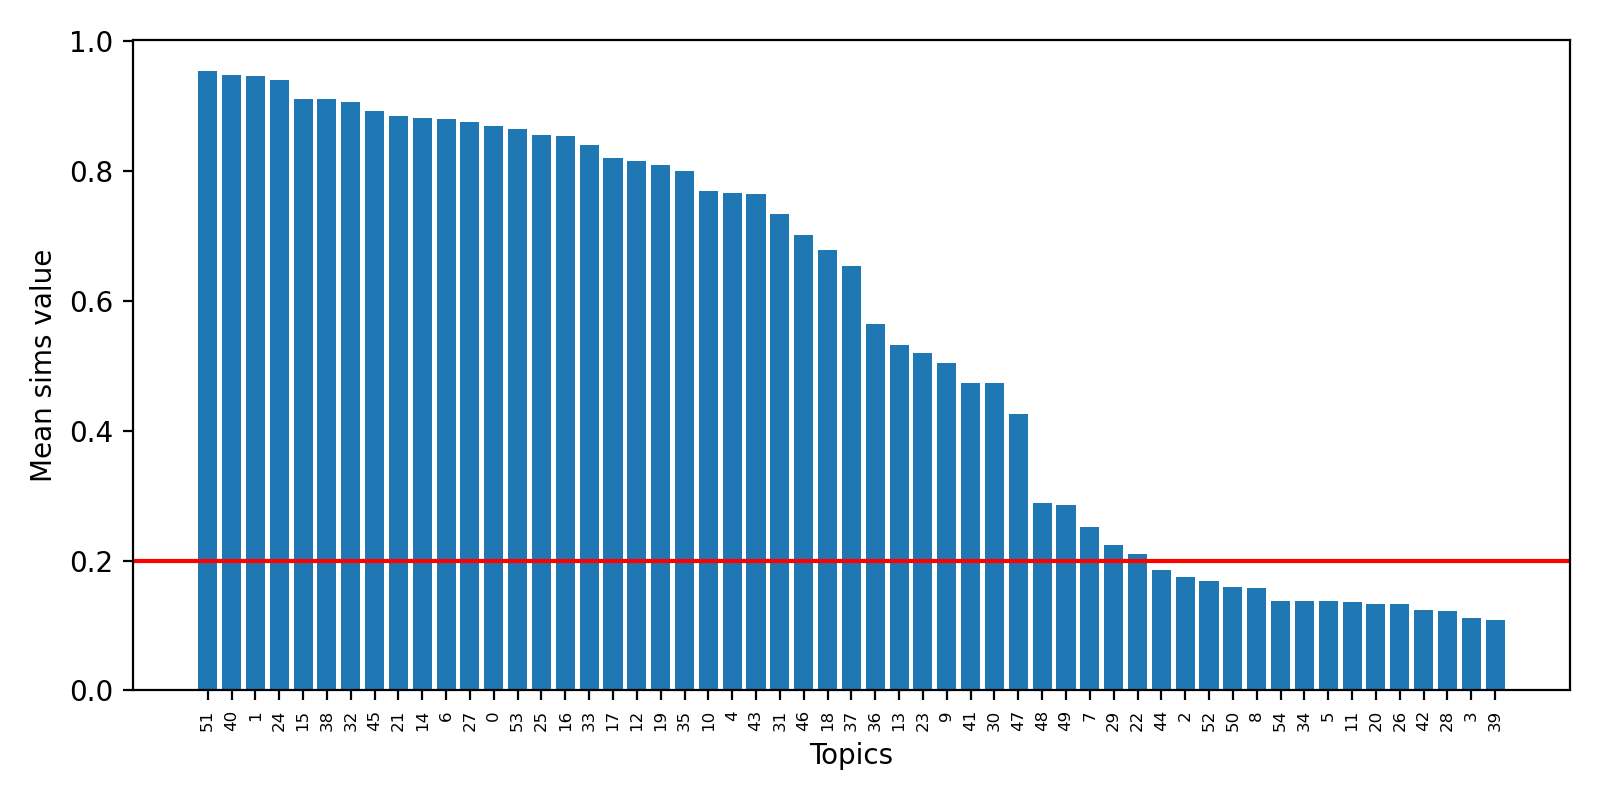

In [22]:
sorted_topics = numpy.argsort(topic_mean_sims)[::-1]
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,4))
axes.bar(numpy.arange(55), topic_mean_sims[sorted_topics])
axes.axhline(0.2, color='r')
axes.set_xticks(numpy.arange(55))
axes.set_xticklabels(numpy.arange(55)[sorted_topics], rotation=90, fontsize=6)
axes.set_xlabel('Topics')
axes.set_ylabel('Mean sims value')
fig.tight_layout()

In [23]:
#Note: for the dissertation chapter I took any topics with a value greater than 0.2, so these look very good
topics_to_use = numpy.where(topic_mean_sims > 0.2)[0]
print(len(topics_to_use))

40


In [24]:
doctopic_frac_subset = doctopic_peaks_frac[:,topics_to_use]
max_to_use = numpy.max(doctopic_frac_subset, axis=1)

In [25]:
print(doctopic_frac_subset.shape)
print(numpy.sum(max_to_use > 0.5))

(30870, 40)
23626


In [26]:
cell_topic_clusts = numpy.argmax(doctopic_peaks_frac, axis=1)
cell_topic_clusts[numpy.where(max_to_use <= 0.5)[0]] = -1

In [27]:
for idx in sorted(set(cell_topic_clusts)):
    print('{!s}: {!s}'.format(idx, len(numpy.where(cell_topic_clusts == idx)[0])))

-1: 7244
0: 615
1: 2588
4: 286
6: 405
7: 20
9: 79
10: 416
12: 321
13: 155
14: 696
15: 712
16: 406
17: 681
18: 103
19: 218
21: 663
22: 12
23: 94
24: 1653
25: 1631
27: 421
29: 12
30: 63
31: 126
32: 1095
33: 247
35: 238
36: 171
37: 104
38: 981
40: 2328
41: 86
43: 468
45: 399
46: 216
47: 67
48: 24
49: 26
51: 4422
53: 378


In [28]:
doctopic_peaks_umap10_res = umap.UMAP(n_components=10, random_state=8872).fit_transform(doctopic_peaks_norm)
print(doctopic_peaks_umap10_res.shape)

(30870, 10)


In [29]:
cell_topic_clusts_expanded = cell_topic_clusts.copy()

#tree = neighbors.KDTree(doctopic_peaks_frac, metric='euclidean')
tree = neighbors.KDTree(doctopic_peaks_umap10_res, metric='euclidean')
min_cluster_size = 150

test_step = numpy.hstack([numpy.ones(5), 0 - numpy.ones(5)])

dist_examples = []
for idx in sorted(set(cell_topic_clusts)):
    topic_cell_idx = list(numpy.where(cell_topic_clusts == idx)[0])
    if idx > -1 and len(topic_cell_idx) < min_cluster_size:
#        meancell = numpy.mean(doctopic_peaks_frac[topic_cell_idx], axis=0)
        cells_added = 0
        deficit = min_cluster_size - len(topic_cell_idx)
        while True:
            kde = neighbors.KernelDensity(bandwidth=1.0,
                                          kernel='gaussian',
                                          metric='euclidean').fit(doctopic_peaks_umap10_res[tuple(topic_cell_idx),:])
            meancell = numpy.mean(kde.sample(200, random_state=8292), axis=0)
#            print(meancell)
            nn_num = max(len(topic_cell_idx) + int(0.25 * len(topic_cell_idx)), 20)
            orig_dist, orig_ind = tree.query([meancell], k=nn_num)
            dist = orig_dist.squeeze()
            ind = orig_ind.squeeze()
            
            #check dist to avoid jumping to another cluster
            if len(dist) >= 1.5 * len(test_step):
                conv_dist = numpy.convolve(dist - numpy.mean(dist), test_step, mode='valid')
                iqr_threshold = max((stats.iqr(conv_dist) * 1.5) + numpy.mean(conv_dist), 1.0)
                outlier_idx = numpy.where(conv_dist > iqr_threshold)[0]
                if len(outlier_idx) > 0:
                    outlier_idx = int(len(test_step)/2) + outlier_idx[0]
                    print('Distance outlier detected; truncating ind at {!s}'.format(outlier_idx))
                    ind = ind[:outlier_idx]
#            print(ind)
            if -1 in cell_topic_clusts_expanded[ind]:# and len(topic_cell_idx) < min_cluster_size:
                to_add_idx = ind[numpy.where(cell_topic_clusts_expanded[ind] == -1)[0][0]]
#                print(to_add_idx)
            else:
                break
            topic_cell_idx.append(to_add_idx)
            cell_topic_clusts_expanded[to_add_idx] = idx
            cells_added += 1
#            print(len(topic_cell_idx))
#            print('...')
#            break
#        break
        
        unique_vals, unique_counts = numpy.unique(cell_topic_clusts_expanded[orig_ind], return_counts=True)
        print(numpy.vstack([unique_vals, unique_counts]))
        if len(topic_cell_idx) < min_cluster_size:
            print('Warning: Added {!s} cells, but not enough to cover the {!s} cell deficit of cluster {!s}'.
                  format(cells_added, deficit, idx))
        print('{!s}: {!s}'.format(idx, len(numpy.where(cell_topic_clusts_expanded == idx)[0])))
        if len(topic_cell_idx) < 50:
            print('Topic {!s} cluster with {!s} cells is too small for peak calling. Setting those cells to -1'.
                  format(idx, len(topic_cell_idx)))
            cell_topic_clusts_expanded[topic_cell_idx] = -1

        dist_examples.append(dist.squeeze())
    else:
        print('{!s}: {!s}'.format(idx, len(topic_cell_idx)))

-1: 7244
0: 615
1: 2588
4: 286
6: 405
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; truncating ind at 411
Distance outlier detected; trun

[[ 23  47  51]
 [ 28 110   8]]
47: 117
[[ 36  48]
 [ 30 113]]
48: 115
[[ 7 49]
 [20 12]]
49: 26
Topic 49 cluster with 26 cells is too small for peak calling. Setting those cells to -1
51: 4422
53: 378


In [30]:
final_topic_clusters = sorted(set(cell_topic_clusts_expanded))
print('{!s} topic clusters passed filtering.'.format(len(final_topic_clusters) - 1))
final_total_cell_count = len(numpy.where(cell_topic_clusts_expanded > -1)[0])
print('{!s} cells ({!s}%) passed filtering.'.format(final_total_cell_count, 
                                                     round((final_total_cell_count/doctopic_peaks_norm.shape[0]) * 100, 2)))
for idx in final_topic_clusters:
    print('{!s}: {!s}'.format(idx, len(numpy.where(cell_topic_clusts_expanded == idx)[0])))

37 topic clusters passed filtering.
24541 cells (79.5%) passed filtering.
-1: 6329
0: 615
1: 2588
4: 286
6: 405
7: 364
9: 156
10: 416
12: 321
13: 155
14: 696
15: 712
16: 406
17: 681
18: 140
19: 218
21: 663
23: 286
24: 1653
25: 1631
27: 421
30: 87
31: 163
32: 1095
33: 247
35: 238
36: 171
37: 154
38: 981
40: 2328
41: 149
43: 468
45: 399
46: 216
47: 117
48: 115
51: 4422
53: 378


<IPython.core.display.Javascript object>


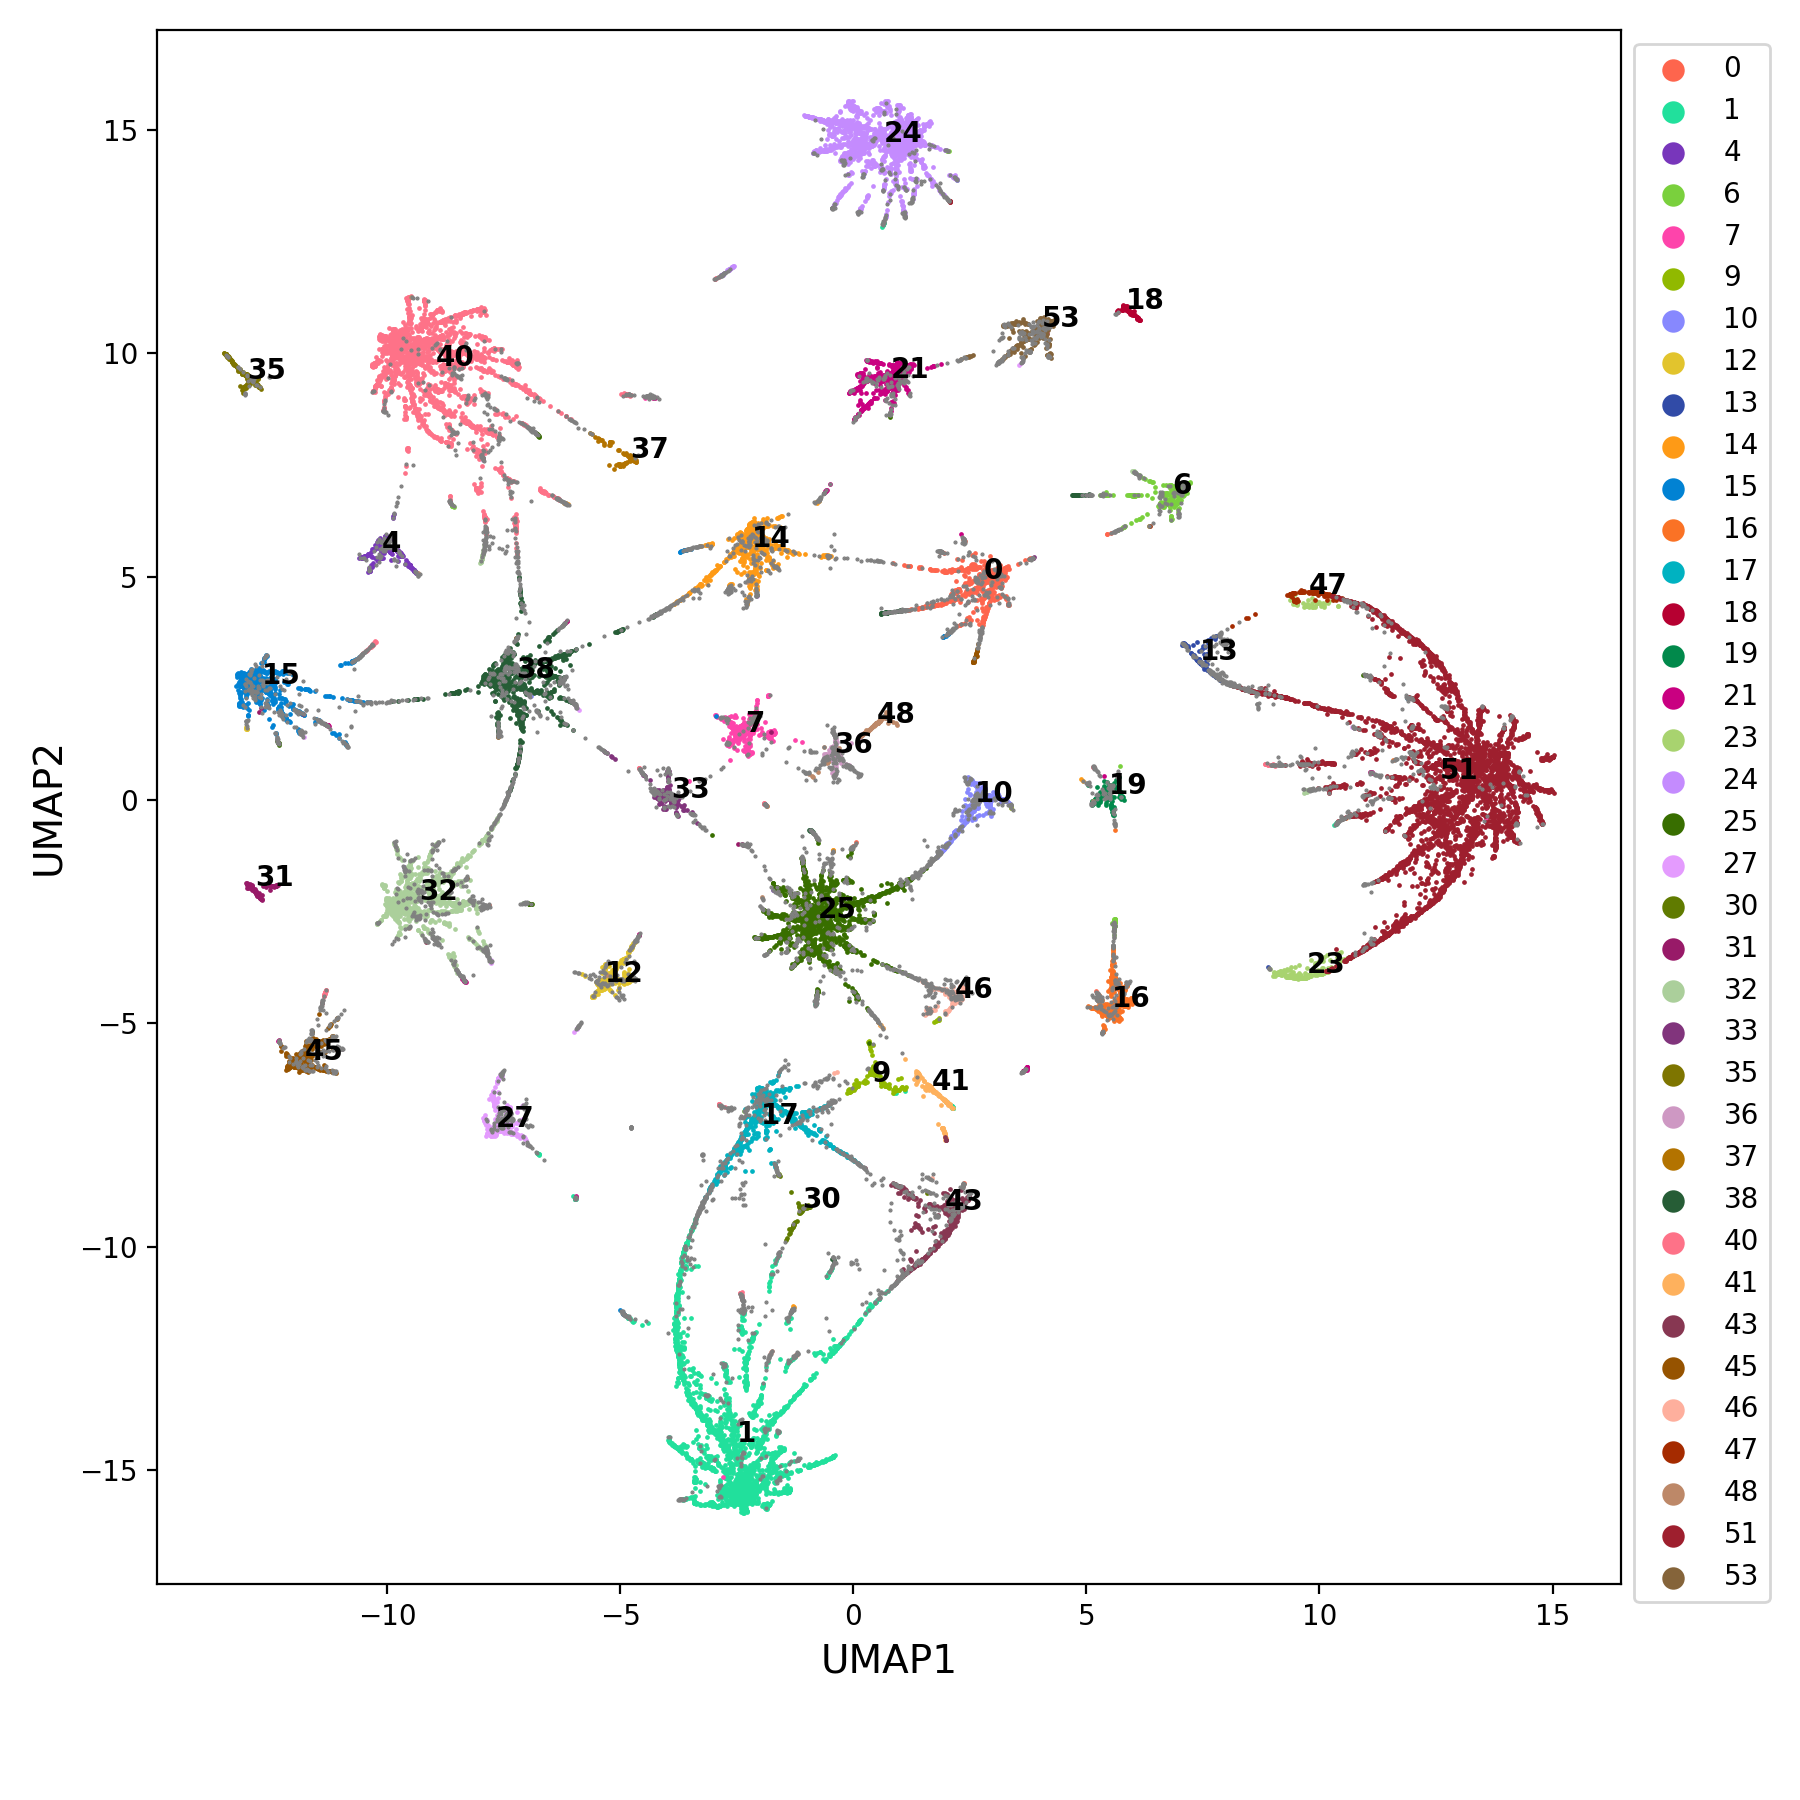

In [40]:
from matplotlib.colors import ListedColormap
colors = numpy.array([[255,101,77],
[33,225,157],
[120,54,188],
[122,209,61],
[255,68,172],
[146,186,0],
[136,137,255],
[227,197,45],
[49,75,168],
[255,155,22],
[1,131,212],
[251,114,37],
[0,179,194],
[183,0,49],
[1,138,75],
[202,0,130],
[169,212,111],
[197,140,255],
[56,110,0],
[229,156,255],
[96,123,0],
[153,26,104],
[172,208,156],
[130,52,124],
[126,117,0],
[207,153,196],
[180,115,0],
[38,93,54],
[255,114,137],
[255,178,93],
[136,55,82],
[151,83,0],
[255,176,158],
[166,43,0],
[190,137,104],
[159,31,46],
[134,100,58]])/256.0
colors = numpy.hstack([colors, numpy.ones((colors.shape[0],1))])
newcmp = ListedColormap(colors)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(9,9))

for idx, num in enumerate(final_topic_clusters[1:]):
    clust_idx = numpy.where(cell_topic_clusts_expanded == num)[0]
    axes.scatter(doctopic_peaks_umap2_res[clust_idx,0], 
                 doctopic_peaks_umap2_res[clust_idx,1], 
                 s=0.5, c=colors[idx,None], label=str(num))
    text_loc = numpy.median(doctopic_peaks_umap2_res[clust_idx], axis=0)
    axes.text(text_loc[0], text_loc[1], str(num), fontweight='bold')

clust_idx = numpy.where(cell_topic_clusts_expanded == -1)[0]
axes.scatter(doctopic_peaks_umap2_res[clust_idx,0], 
             doctopic_peaks_umap2_res[clust_idx,1], 
             c='grey',
             s=0.25)

#for idx, num in enumerate(final_topic_clusters):
#    topic_idx_map[numpy.where(topic_idx_map == num)[0]] = idx
#
#s = axes.scatter(doctopic_umap2_res[in_clust_idx,0], 
#                 doctopic_umap2_res[in_clust_idx,1], 
#                 c=topic_idx_map,
#                 cmap=newcmp,
#                 s=0.5)
axes.set_ylabel('UMAP2', fontsize=14)
axes.set_xlabel('UMAP1', fontsize=14)
axes.legend(bbox_to_anchor=[1.0,1.0], markerscale=10)
#cbar = fig.colorbar(s, ticks=numpy.arange(len(topic_nums)))
#cbar.ax.set_yticklabels(topic_nums, fontsize=10)
#fig.savefig('./annotated_umap_clusters.pdf', bbox_inches='tight')
fig.tight_layout()

## Construct an AnnData object and save in loom format

In [32]:
def add_lda_result_to_anndata_obj(anndata_obj, lda_base, lda_cellnames, lda_peak_bed):

    filt_cellnames = numpy.loadtxt(lda_cellnames, dtype=object)[:,0]
    filt_cellnames_set = set(filt_cellnames)
    filt_cellnames_map = [(True, idx, numpy.where(filt_cellnames == elt)[0][0])
                          if elt in filt_cellnames_set else (False, idx, numpy.nan)
                          for idx, elt in enumerate(anndata_obj.obs.index.values)]
    unfilt_cellnames_idx, filt_cellnames_idx = [list(idx_tuple) for idx_tuple in zip(*[(elt[1], elt[2]) for elt in filt_cellnames_map if elt[0] is True])]
    anndata_obj.obs['lda_cell'] = [elt[0] for elt in filt_cellnames_map]

    theta = numpy.loadtxt(lda_base + '.theta', delimiter=',', dtype=float)
    unfiltered_theta = numpy.ones((len(filt_cellnames_map), theta.shape[1])) * numpy.nan
    unfiltered_theta[unfilt_cellnames_idx] = theta[filt_cellnames_idx]
    anndata_obj.obsm['lda_theta'] = unfiltered_theta

    col_means = numpy.mean(theta.T, axis=0)
    theta_norm = theta.T - col_means
    l2_for_norm = (theta_norm ** 2).sum(axis=0).flatten() ** 0.5
    theta_norm /= l2_for_norm
    theta_norm = theta_norm.T
    unfiltered_theta_norm = numpy.ones(unfiltered_theta.shape) * numpy.nan
    unfiltered_theta_norm[unfilt_cellnames_idx] = theta_norm[filt_cellnames_idx]
    anndata_obj.obsm['lda_theta_norm'] = unfiltered_theta_norm

    doctopic = numpy.loadtxt(lda_base + '.docTopic', delimiter=',', dtype=float)
    unfiltered_doctopic = numpy.ones(unfiltered_theta.shape) * numpy.nan
    unfiltered_doctopic[unfilt_cellnames_idx] = doctopic[filt_cellnames_idx]
    anndata_obj.obsm['lda_doctopic'] = unfiltered_doctopic

    doctopic_frac = (doctopic.T/doctopic.sum(axis=1)).T
    unfiltered_doctopic_frac = numpy.ones(unfiltered_theta.shape) * numpy.nan
    unfiltered_doctopic_frac[unfilt_cellnames_idx] = doctopic_frac[filt_cellnames_idx]
    anndata_obj.obsm['lda_doctopic_frac'] = unfiltered_doctopic_frac

    filt_peaks = numpy.loadtxt(lda_peak_bed, dtype=object)
    filt_peaks_str = ['{!s}\t{!s}\t{!s}'.format(*filt_peaks[idx,:3])
                      for idx in range(filt_peaks.shape[0])]
    filt_peaks_set = set(filt_peaks_str)
    unfilt_peaks_str = ['{!s}\t{!s}\t{!s}'.format(anndata_obj.var['chr'][idx],
                                                  anndata_obj.var['start'][idx],
                                                  anndata_obj.var['stop'][idx])
                        for idx in range(anndata_obj.var.shape[0])]
    filt_peaks_map = [(True, idx, filt_peaks_str.index(elt))
                      if elt in filt_peaks_set else (False, idx, numpy.nan)
                      for idx, elt in enumerate(unfilt_peaks_str)]
    unfilt_peaks_idx, filt_peaks_idx = [list(idx_tuple) for idx_tuple in zip(*[(elt[1], elt[2]) for elt in filt_peaks_map if elt[0] is True])]
    anndata_obj.var['lda_peak'] = [elt[0] for elt in filt_peaks_map]

    phi = numpy.loadtxt(lda_base + '.phi', delimiter=',', dtype=float).T
    unfiltered_phi = numpy.ones((anndata_obj.var.shape[0], phi.shape[1])) * numpy.nan
    unfiltered_phi[unfilt_peaks_idx] = phi[filt_peaks_idx]
    anndata_obj.varm['lda_phi'] = unfiltered_phi

    wordtopic = numpy.loadtxt(lda_base + '.wordTopic', delimiter=',', dtype=float)
    unfiltered_wordtopic = numpy.ones(unfiltered_phi.shape) * numpy.nan
    unfiltered_wordtopic[unfilt_peaks_idx] = wordtopic[filt_peaks_idx]
    anndata_obj.varm['lda_wordtopic'] = unfiltered_wordtopic

    wordtopic_frac = (wordtopic.T/wordtopic.sum(axis=1)).T
    unfiltered_wordtopic_frac = numpy.ones(unfiltered_phi.shape) * numpy.nan
    unfiltered_wordtopic_frac[unfilt_peaks_idx] = wordtopic_frac[filt_peaks_idx]
    anndata_obj.varm['lda_wordtopic_frac'] = unfiltered_wordtopic_frac

    return

def read_in_bow(bow_path, cell_names_path, feature_info_path, gene_name_map=None):
    try:
        bow_data_sparse = numpy.loadtxt(bow_path, dtype=int, skiprows=3)
    except StopIteration:
        #probably NFS lag; just wait a few seconds and try again
        time.sleep(10)
        bow_data_sparse = numpy.loadtxt(bow_path, dtype=int, skiprows=3)
    open_func, open_mode = (gzip.open, 'rb') if bow_path.endswith('.gz') else (open, 'rb')
    with open_func(bow_path, open_mode) as lines_in:
        cellnum = int(lines_in.readline().decode().strip())
        featnum = int(lines_in.readline().decode().strip())
    bow_data = sps.csr_matrix((bow_data_sparse[:,2],
                               (bow_data_sparse[:,0] - 1,
                                bow_data_sparse[:,1] - 1)),
                              shape=(cellnum, featnum))

    try:
        cell_names = numpy.loadtxt(cell_names_path, dtype=object)[:,0]
    except StopIteration:
        time.sleep(10)
        cell_names = numpy.loadtxt(cell_names_path, dtype=object)[:,0]

    try:
        feature_info_bed = numpy.loadtxt(feature_info_path, dtype=object)
    except StopIteration:
        time.sleep(10)
        feature_info_bed = numpy.loadtxt(feature_info_path, dtype=object)
    col_names = ['chr', 'start', 'stop', 'name', 'score', 'strand']
    num_cols = feature_info_bed.shape[1]
    if num_cols <= 6:
        col_names = col_names[:num_cols]
    else:
        col_names = col_names + list(numpy.arange(6, num_cols).astype(str))

    anndata_obj = anndata.AnnData(X=bow_data,
                                  obs=pandas.DataFrame(index=cell_names),
                                  var=pandas.DataFrame(data=feature_info_bed,
                                                       columns=col_names))
    if gene_name_map is not None:
        gene_name_map = numpy.loadtxt(gene_name_map, delimiter='\t', dtype=object)
        gene_name_map = dict([gene_name_map[idx] for idx in range(gene_name_map.shape[0])])
        anndata_obj.var['common_name'] = [gene_name_map.get(elt, elt) for elt in anndata_obj.var.name]

    return anndata_obj

In [34]:
#make and save anndata object
import anndata
import pandas

#first, read in the original BOW data (the unfiltered data)
orig_peaktable_path = '../all_peaks.merged.allcells.bow'
orig_cell_names_path = '../all_peaks.merged.allcells.zeros_filtered.indextable.txt'
orig_peak_names_path = '../all_peaks.merged.allcells.zeros_filtered.bed'

anndata_obj = read_in_bow(orig_peaktable_path, orig_cell_names_path, orig_peak_names_path)

#next, add the LDA results, taking into account that some of the cells/peaks were filtered out before running LDA
lda_base = './0000_topics55_alpha3.000_beta2000.000/topic_mode'
lda_cellnames = './filtered_peaks_iqr4.0_low_cells.indextable.txt'
lda_peak_bed = './filtered_peaks_iqr4.0_low_cells.extra_cols.bed'
add_lda_result_to_anndata_obj(anndata_obj, lda_base, lda_cellnames, lda_peak_bed)

print(anndata_obj)

Transforming to str index.


AnnData object with n_obs × n_vars = 30930 × 34339 
    obs: 'lda_cell'
    var: 'chr', 'start', 'stop', 'lda_peak'
    obsm: 'lda_theta', 'lda_theta_norm', 'lda_doctopic', 'lda_doctopic_frac'
    varm: 'lda_phi', 'lda_wordtopic', 'lda_wordtopic_frac'


In [35]:
cell_topic_clusts_map_orig = dict(list(numpy.loadtxt('./cell_name_to_topic_cluster_map.txt', 
                                                     delimiter='\t', dtype=object)))
cell_topic_clusts_orig = [int(cell_topic_clusts_map_orig.get(elt, '-1')) 
                          for elt in anndata_obj.obs.index.values]
print(len(cell_topic_clusts_orig))

anndata_obj.obs['topic_cluster'] = cell_topic_clusts_orig

30930


In [37]:
orig_umap2 = numpy.loadtxt('./umap2_coords.tab', delimiter='\t')
umap_to_add = numpy.zeros((anndata_obj.shape[0], orig_umap2.shape[1])) * numpy.nan
anndata_idx = numpy.where(anndata_obj.obs.lda_cell)[0]
umap_idx = [numpy.where(cell_names == elt)[0][0] for elt in anndata_obj.obs[anndata_obj.obs.lda_cell].index.values]
umap_to_add[anndata_idx] = orig_umap2[umap_idx]
print(umap_to_add.shape)
anndata_obj.obsm['umap2'] = umap_to_add

orig_umap3 = numpy.loadtxt('./umap3_coords.tab', delimiter='\t')
umap_to_add = numpy.zeros((anndata_obj.shape[0], orig_umap3.shape[1])) * numpy.nan
anndata_idx = numpy.where(anndata_obj.obs.lda_cell)[0]
umap_idx = [numpy.where(cell_names == elt)[0][0] for elt in anndata_obj.obs[anndata_obj.obs.lda_cell].index.values]
umap_to_add[anndata_idx] = orig_umap3[umap_idx]
print(umap_to_add.shape)
anndata_obj.obsm['umap3'] = umap_to_add

orig_umap10 = numpy.loadtxt('./umap10_coords.tab', delimiter='\t')
umap_to_add = numpy.zeros((anndata_obj.shape[0], orig_umap10.shape[1])) * numpy.nan
anndata_idx = numpy.where(anndata_obj.obs.lda_cell)[0]
umap_idx = [numpy.where(cell_names == elt)[0][0] for elt in anndata_obj.obs[anndata_obj.obs.lda_cell].index.values]
umap_to_add[anndata_idx] = orig_umap10[umap_idx]
print(umap_to_add.shape)
anndata_obj.obsm['umap10'] = umap_to_add

print(anndata_obj)

(30930, 2)
(30930, 3)
(30930, 10)
AnnData object with n_obs × n_vars = 30930 × 34339 
    obs: 'lda_cell', 'topic_cluster'
    var: 'chr', 'start', 'stop', 'lda_peak'
    obsm: 'lda_theta', 'lda_theta_norm', 'lda_doctopic', 'lda_doctopic_frac', 'umap2', 'umap3', 'umap10'
    varm: 'lda_phi', 'lda_wordtopic', 'lda_wordtopic_frac'


In [38]:
anndata_obj.write_loom('./refinement_lda_results.loom', write_obsm_varm=True)

In [38]:
#save umap coordinates
numpy.savetxt('./umap2_coords.tab', anndata_obj.obsm['umap2'], delimiter='\t')
numpy.savetxt('./umap3_coords.tab', anndata_obj.obsm['umap3'], delimiter='\t')
numpy.savetxt('./umap10_coords.tab', anndata_obj.obsm['umap10'], delimiter='\t')

## Make Figures showing thetas and wordTopic distributions

1.0 1.0
(12.0, 28.0)


<IPython.core.display.Javascript object>


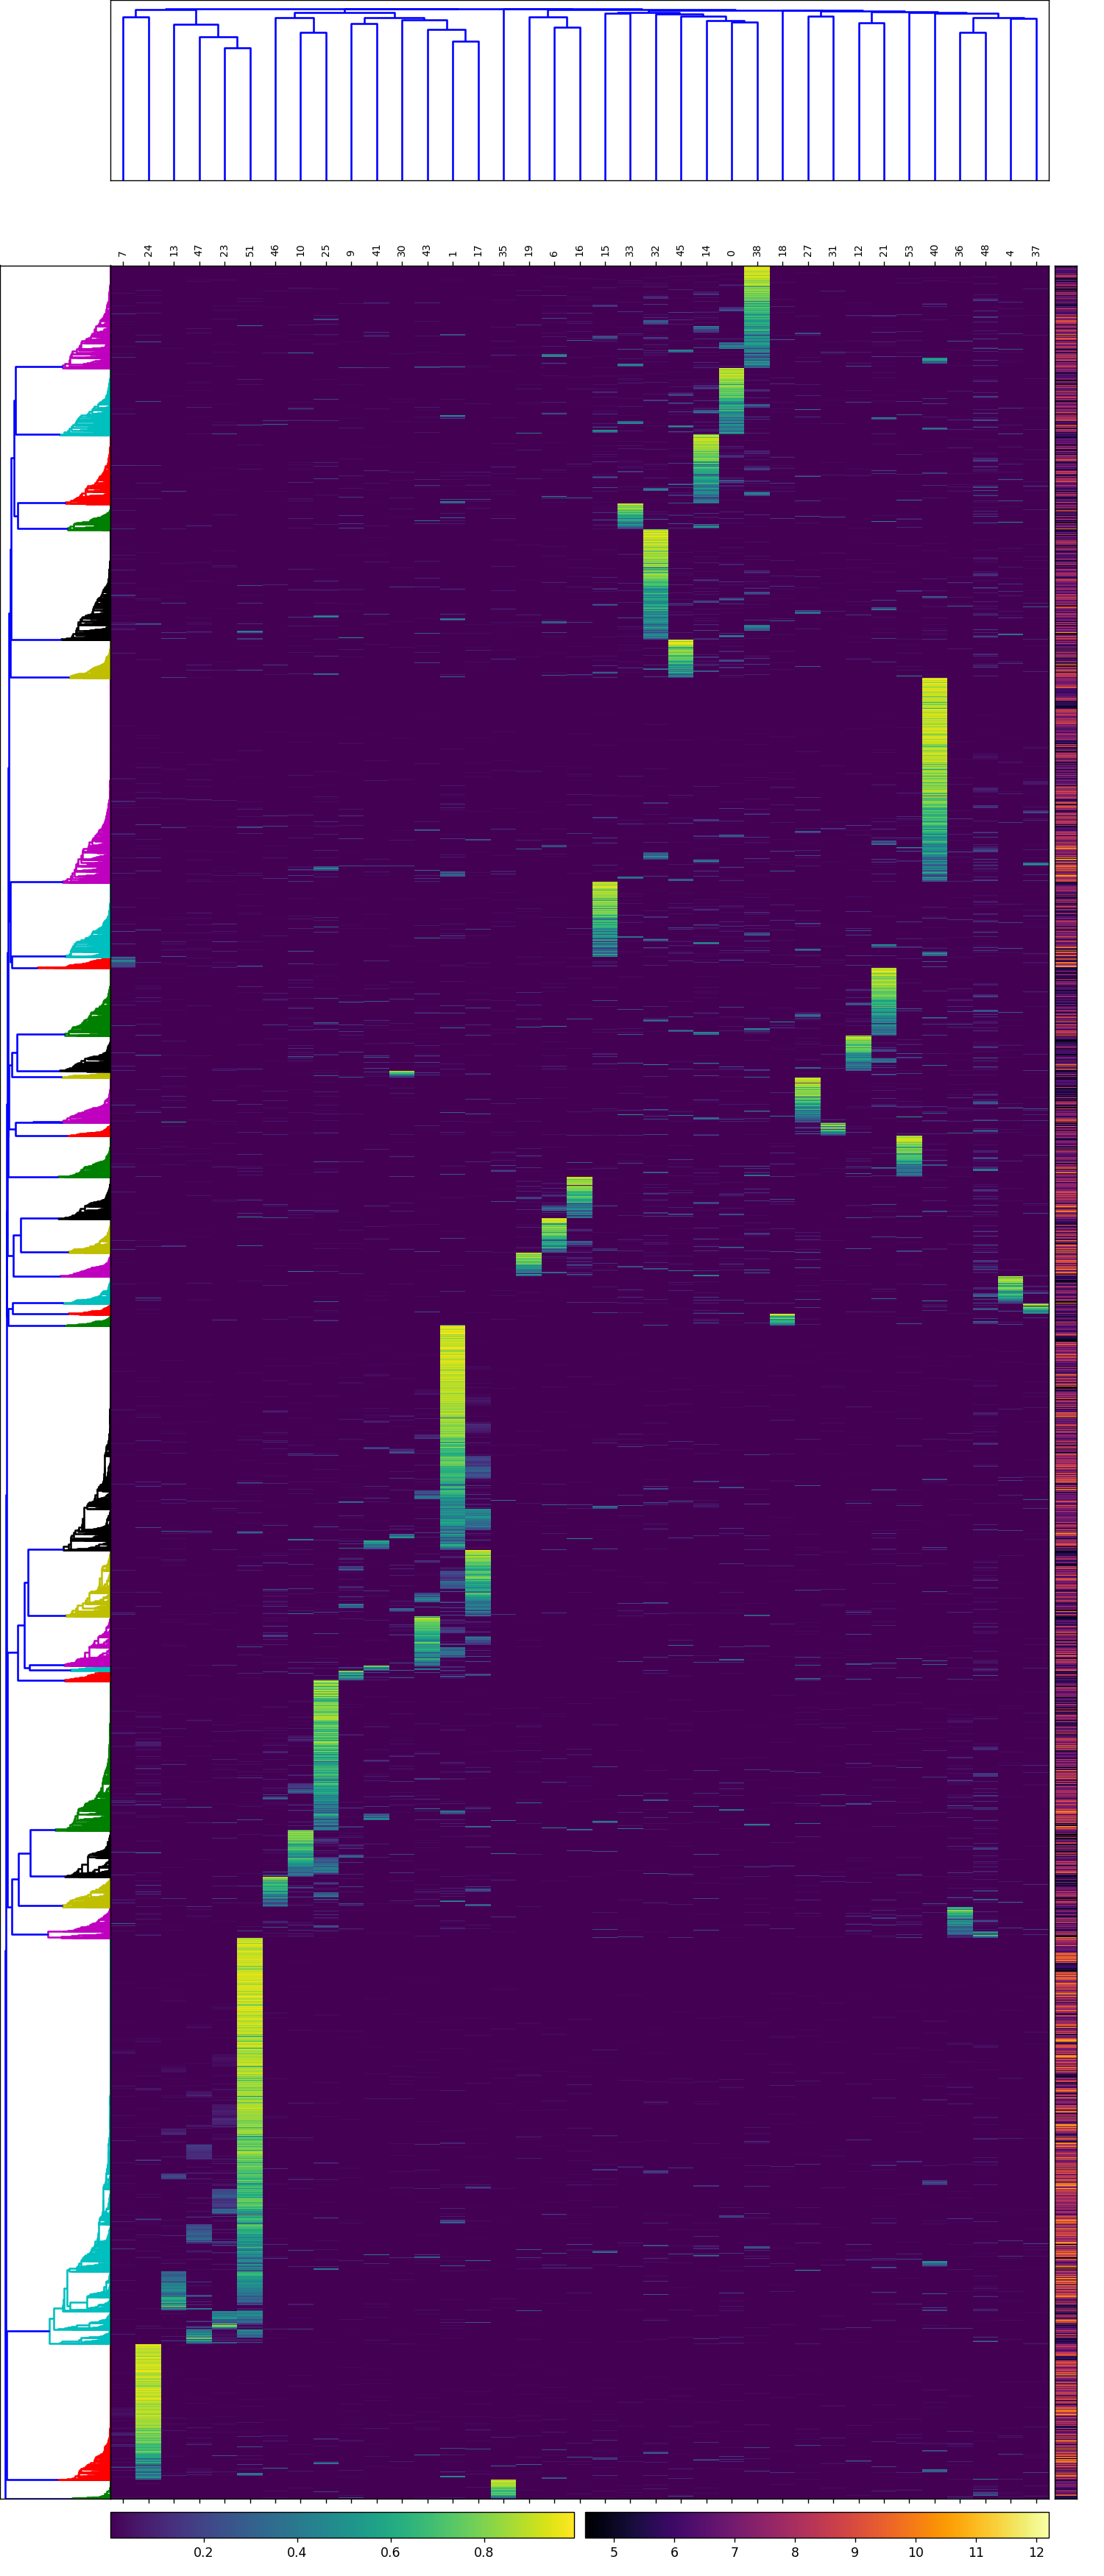

In [43]:
topics_for_clustering = final_topic_clusters[1:]
cell_coverage = numpy.log2(peak_data_array.sum(axis=1))

# axm, placement of heatmap for the data matrix
[axm_x, axm_y, axm_w, axm_h] = [0.1, 0.03, 0.85, 0.867]

# ax1, placement of dendrogram 1, to the left of the heatmap
[ax1_x, ax1_y, ax1_w, ax1_h] = [0, 0.03, 0.1, 0.867]

# ax2, placement of dendrogram 2, on the top of the heatmap
[ax2_x, ax2_y, ax2_w, ax2_h] = [0.1, 0.93, 0.85, 0.07]

# axcov - placement of the cell coverage plot
[axcov_x, axcov_y, axcov_w, axcov_h] = [0.955, 0.03, 0.02, 0.867]

# axcb - placement of the color legend
[axcb_x, axcb_y, axcb_w, axcb_h] = [0.1, 0.015, 0.42, 0.01]

# axcb2 - placement of the coverage plot color legend
[axcb2_x, axcb2_y, axcb2_w, axcb2_h] = [0.53, 0.015, 0.42, 0.01]

master_size = (12,28) + doctopic_peaks_frac.shape
height_factor = doctopic_peaks_frac.shape[0]/master_size[2]
width_factor = doctopic_peaks_frac.shape[1]/master_size[3]
print(height_factor, width_factor)
print((master_size[0] * width_factor, master_size[1]*height_factor))
fig = pyplot.figure(figsize=(master_size[0] * width_factor, master_size[1]*height_factor))

#plot dendrogram of rows
ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h])
#Note: these were treated as samples by features, not distance matrices...
#dist1 = distance.squareform(distance.pdist(doctopic_norm, metric='cosine'))
dist1 = distance.pdist(doctopic_peaks_frac[:,topics_for_clustering], metric='cosine')
Y1 = hierarchy.linkage(dist1, method='average')
Z1 = hierarchy.dendrogram(Y1, orientation='left', no_labels=True, ax=ax1, count_sort=True)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.set_yticklabels([])

#plot dendrogram of cols
ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h])
#Note: these were treated as samples by features, not distance matrices...
#dist2 = distance.squareform(distance.pdist(doctopic_norm.T, metric='cosine'))
dist2 = distance.pdist(doctopic_peaks_frac[:, topics_for_clustering].T, metric='cosine')
Y2_nontf = hierarchy.linkage(dist2, method='average')
Z2_nontf = hierarchy.dendrogram(Y2_nontf, orientation='top', no_labels=True, ax=ax2, count_sort=True)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

#plot heatmap
ax3 = fig.add_axes([axm_x, axm_y, axm_w, axm_h])
h_index1 = Z1['leaves']
h_index2 = Z2_nontf['leaves']
resort_x = doctopic_peaks_frac[:,topics_for_clustering][h_index1,:]
resort_x = resort_x[:,h_index2]
im = ax3.matshow(resort_x, cmap='viridis', aspect='auto', origin='lower')

#for elt in range(0, 10000, 500):
#    ax3.axhline(elt, color='r')

xlocs = numpy.arange(doctopic_peaks_frac[:,topics_for_clustering].shape[1])
ax3.set_xticks(xlocs)
ax3.set_xticklabels(numpy.array(topics_for_clustering)[h_index2], fontsize=8, rotation=90)
ax3.set_yticks([])

#plot cell coverage
axcov = fig.add_axes([axcov_x, axcov_y, axcov_w, axcov_h])
im_cov = axcov.matshow(cell_coverage[h_index1,None], vmin=min(cell_coverage), 
                       vmax=max(cell_coverage), cmap='inferno', aspect='auto', origin='lower')
axcov.set_xticks([])
axcov.set_yticks([])

#left, bottom, width, height
cbaxes = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h])
cb = fig.colorbar(im, orientation='horizontal', cax=cbaxes)

cbaxes2 = fig.add_axes([axcb2_x, axcb2_y, axcb2_w, axcb2_h])
cb2 = fig.colorbar(im_cov, orientation='horizontal', cax=cbaxes2)

#ax3.set_yticks(numpy.arange(doctopic_norm.shape[0]))
#ax3.set_yticklabels(numpy.array(x_labels)[h_index1])

fig.show()